In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 40
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
POLLUTANTS = ['PM25', 'CO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Months case

In [2]:
windows_map = read_ontario(granularity='months', cache=True)
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [3]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

windows.shape

In [4]:
windows.shape
dates.shape

(1208,)

In [5]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [6]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 1208, T: 28, D: 2 
(1208, 2, 28)


In [25]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC, VAE_FL

# cae = DCEC(mts.D, mts.T, feature_size=10, n_clusters=5)
cae = VAE_FL(mts.D, mts.T, feature_size=10)

cae.fit(mts.X, epochs=500, batch_size=320)

Epoch[1] Train loss    avg: 0.5318728312849998
Epoch[1] Train KL loss    avg: 0.6598539873957634
Epoch[50] Train loss    avg: 0.0174333518370986
Epoch[50] Train KL loss    avg: 0.008105275919660926
Epoch[100] Train loss    avg: 0.010683812899515033
Epoch[100] Train KL loss    avg: 0.0034602214582264423
Epoch[150] Train loss    avg: 0.00906587578356266
Epoch[150] Train KL loss    avg: 0.002129100204911083
Epoch[200] Train loss    avg: 0.0079117949353531
Epoch[200] Train KL loss    avg: 0.0015001031861174852
Epoch[250] Train loss    avg: 0.006768264225684106
Epoch[250] Train KL loss    avg: 0.001125261071138084
Epoch[300] Train loss    avg: 0.006179544376209378
Epoch[300] Train KL loss    avg: 0.0011840075312647969
Epoch[350] Train loss    avg: 0.0053590378956869245
Epoch[350] Train KL loss    avg: 0.0009327847947133705
Epoch[400] Train loss    avg: 0.004913889104500413
Epoch[400] Train KL loss    avg: 0.0007557788048870862
Epoch[450] Train loss    avg: 0.004512503393925726
Epoch[450] Tr

In [26]:
from source.featlearn.autoencoder_lr import AutoencoderFL, DCEC

# cae.fit(mts.X, epochs=100, batch_size=320, gamma=100)
_, mts.features = cae.encode(mts.X)


In [18]:
# # clusters
# preds = np.argmax(clusters, axis=1)
# print(np.unique(preds))

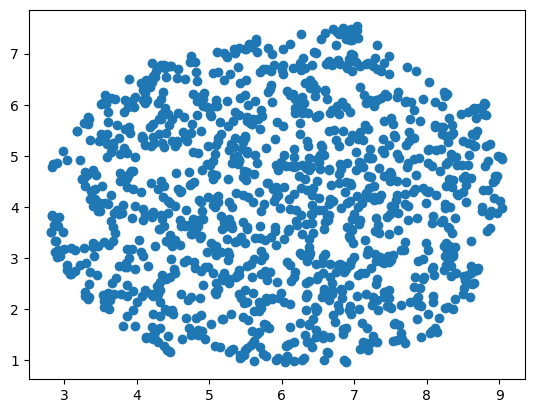

In [29]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine')
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y = month_ids)
coords = reducer.fit_transform(mts.features)
# plt.scatter(coords[:, 0], coords[:, 1], c=preds)
plt.scatter(coords[:, 0], coords[:, 1])

In [ ]:
# year_ids[year_ids==2011]

In [ ]:
# mts.features.min()
from sklearn.decomposition import PCA
d = mts.X.shape[2]
n = mts.X.shape[0]

features = mts.features.reshape([n, int(mts.features.shape[1] / d), d])
dfeatures = np.zeros([n, d])
for i in range(d):
    reducer = PCA(n_components=1)
    dfeatures[:,i] = reducer.fit_transform(features[:, :, i]).squeeze()


In [168]:
# dfeatures.shape
# year_ids.shape
# dfeatures[year_ids==2011].shape
# dfeatures[year_ids!=2011].shape

In [ ]:
years = np.unique(month_ids)
group_ids = month_ids

fcs = []

for target in years:

    ccpca = CCPCA(n_components=1)
    # target = 2012
    ccpca.fit(
        dfeatures[group_ids==target],
        dfeatures[group_ids!=target],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )


    coords2 = ccpca.transform(dfeatures[group_ids==target])
    # coords2 = ccpca.transform(dfeatures[year_ids!=2011])
    # coords2 = ccpca.transform(dfeatures)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs.append(cpca_fcs)
    # print(cpca_fcs)
    # print(best_alpha)
    # plt.scatter(coords2[:, 0], coords2[:, 1])


[ 1  2  3  4  5  6  7  8  9 10 11 12]


<BarContainer object of 12 artists>

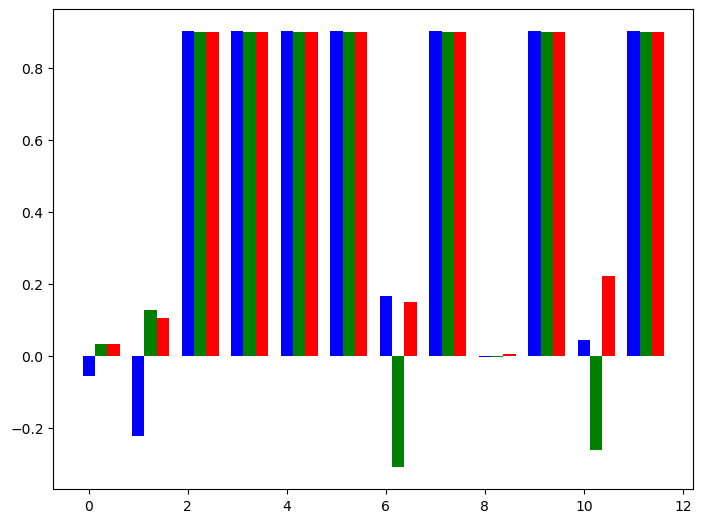

In [ ]:
print(years)
fcs = np.array(fcs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.array([i for i in range (len(years))])
ax.bar(X + 0.00, fcs[:,0], color = 'b', width = 0.25)
ax.bar(X + 0.25, fcs[:,1], color = 'g', width = 0.25)
ax.bar(X + 0.50, fcs[:,2], color = 'r', width = 0.25)
# plt.bar(, fcs[:,0])

In [ ]:
from server.source.storage import MTSStorage

# storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_months.npy'))    
storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_days.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 358 -  T: 28 - D: 6


!pwd